In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys,os
sys.path.append('..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.strategy import StrategyBase, OptParam, OptParamArray
from backtester.swarms.ranking import SwarmRanker
from backtester.swarms.rebalancing import SwarmRebalance
from backtester.swarms.filters import SwarmFilter
from backtester.costs import CostsManagerEXOFixed
from backtester.exoinfo import EXOInfo
from backtester.swarms.rankingclasses import *
from backtester.swarms.swarm import Swarm

import statsmodels.tsa.api as smt

import pandas as pd
import numpy as np
import scipy

In [66]:
from scripts.settings import *
try:
    from scripts.settings_local import *
except:
    pass

from exobuilder.data.exostorage import EXOStorage

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)


exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = 'CL'  # ES Collars (incl Bearish, Bullish, BW and vanilla)

[print(exo) for exo in storage.exo_list(exo_filter)];

CL_BullishCollarBW
CL_BearishCollarBW
CL_CallSpread
CL_PutSpread
CL_ContFut
CL_SMART_Ichimoku_Long
CL_SMART_Ichimoku_VerticalSpread_Bullish
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged_test
CL_SmartEXO_Ichi_Bearish_Straddle_BullCall_Spread_0Delta_EXP
CL_SmartEXO_Ichi__BullCall_Spread_Delta_150_EXP
CL_SmartEXO_Ichi_Bearish_Straddle_150Delta
CL_SmartEXO_Ichi_Bearish_Put_Spread_150Delta
CL_SmartEXO_Ichi_Bullish_Straddle_150Delta_ExpHedged_small_BearStraddle
CL_SmartEXO_Ichi_Call_Spread_150Delta_Bi
CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi
CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi_no_neutral
CL_SmartEXO_Bullish_Ichi_Short_Put_Spread_150Delta_Bi
CL_SMART_Ichimoku_Straddle_Bullish
CL_Quandl-EXO-CL-CallSpread


In [4]:
class Strategy_SeasDecomp_Residuals(StrategyBase):
    name = 'Strategy_SeasDecomp_Residuals'


    def __init__(self, strategy_context):
        # Initialize parent class
        super().__init__(strategy_context)
   
    def calc_entry_rules(self, pctrank_value, z_score_value, z_score_period, rules_index):

        #sd = smt.seasonal_decompose(self.data.exo.asfreq('B').ffill().dropna().iloc[:])#.plot()
        
        # Lamb values can be an optimized value
        
        #resid = self.data.exo - smt.filters.hpfilter(self.data.exo, lamb=50000)[1]
        #resid = self.data.exo - self.data.exo.ewm(10).mean()
        
        resid = pd.Series(NaN, index=self.data.exo.index)

        window = 10
        
        for i in range(window, len(self.data.exo)):
            hpfilt_slice = smt.filters.hpfilter(self.data.exo.iloc[:i], lamb=50000)[0]
            resid.iloc[i] = np.mean(hpfilt_slice[-1:])
        
        resid_pctrank = resid.rank(pct=True)
        
        resid_zscore = (resid - resid.rolling(z_score_period).mean()) / resid.rolling(z_score_period).std()
        
        signals_df = pd.DataFrame()
        signals_df['exo'] = self.data.exo
        
        if rules_index == 0:
            entry_signal = pd.Series(resid_pctrank >= pctrank_value, name='entry_signal')
            return signals_df.join(entry_signal).fillna(False).entry_signal
        
        if rules_index == 1:
            entry_signal = pd.Series(resid_pctrank <= pctrank_value, name='entry_signal')
            return signals_df.join(entry_signal).fillna(False).entry_signal
        
        if rules_index == 2:
            entry_signal = pd.Series(resid_zscore >= z_score_value, name='entry_signal')
            return signals_df.join(entry_signal).fillna(False).entry_signal
        
        if rules_index == 3:
            entry_signal = pd.Series(resid_zscore <= -z_score_value, name='entry_signal')
            return signals_df.join(entry_signal).fillna(False).entry_signal
        
        if rules_index > 3:
            raise ValueError('Rules index parameter must be in range of 0-3')

    def calc_exit_rules(self, pctrank_value, exit_rules_index):

        #sd = smt.seasonal_decompose(self.data.exo.asfreq('B').ffill().dropna().iloc[:])#.plot()
        
        #resid = self.data.exo - smt.filters.hpfilter(self.data.exo, lamb=50000)[1]
        resid = self.data.exo - self.data.exo.ewm(10).mean()
        
        signals_df = pd.DataFrame()
        signals_df['exo'] = self.data.exo
        
        resid_pctrank = resid.rank(pct=True)
        
        resid_zero_line = pd.Series(0.0, index=resid.index)
        
        signals_df = pd.DataFrame()
        signals_df['exo'] = self.data.exo
        
        if exit_rules_index == 0:
            exit_signal = pd.Series(resid_pctrank >= pctrank_value, name='exit_signal')
            return signals_df.join(exit_signal).fillna(False).exit_signal
        
        if exit_rules_index == 1:
            exit_signal = pd.Series(resid_pctrank <= pctrank_value, name='exit_signal')
            return signals_df.join(exit_signal).fillna(False).exit_signal      
        
        if exit_rules_index == 2:
            exit_signal = pd.Series((CrossDown(resid, resid_zero_line)) | (CrossUp(resid, resid_zero_line)), name='exit_signal')
            return signals_df.join(exit_signal).fillna(False).exit_signal
        
            
    def calculate(self, params=None, save_info=False):
    #
    #
    #  Params is a tripple like (50, 10, 15), where:
    #   50 - slow MA period
    #   10 - fast MA period
    #   15 - median period
    #
    #  On every iteration of swarming algorithm, parameter set will be different.
    #  For more information look inside: /notebooks/tmp/Swarming engine research.ipynb
    #

        if params is None:
            # Return default parameters
            direction, pctrank_value, z_score_value, z_score_period, rules_index, exit_rules_index = self.default_opts()
        else:
            # Unpacking optimization params
            #  in order in self.opts definition
            direction, pctrank_value, z_score_value, z_score_period, rules_index, exit_rules_index = params

        # Defining EXO price
        px = self.data.exo
                
        entry_rule = self.calc_entry_rules(pctrank_value, z_score_value, z_score_period, rules_index)

        if direction == 1:
            #exit_rule = (CrossDown(px, trailing_stop))  # Cross down for longs
            exit_rule = self.calc_exit_rules(pctrank_value, exit_rules_index)
            
        elif direction == -1:
            
            #exit_rule = (CrossUp(px, trailing_stop))  # Cross up for shorts, Cross down for longs
            exit_rule = self.calc_exit_rules(pctrank_value, exit_rules_index)
        # Swarm_member_name must be *unique* for every swarm member
        # We use params values for uniqueness
        swarm_member_name = self.get_member_name(params)

        #
        # Calculation info
        #
        calc_info = None
        if save_info:
            calc_info = {'trailing_stop': trailing_stop}

        return swarm_member_name, entry_rule, exit_rule, calc_info

## Script settings

In [83]:
STRATEGY_CONTEXT = {
    'strategy': { 
        'class': Strategy_SeasDecomp_Residuals,
        'exo_name': 'CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi',        # <---- Select and paste EXO name from cell above
        'exo_storage': storage,          
        'opt_params': [
                        #OptParam(name, default_value, min_value, max_value, step)
                        OptParamArray('Direction', [-1]),
                        #OptParam('Pct rank value', 9, 0, 1, 0.2),
                        OptParamArray('Pct rank value', [0.1,0.9,0.8,0.2,0.3,0.7]),
                        OptParam('Z Score value', 9, 3, 3, 1),
                        OptParam('Z Score period', 9, 50, 50, 50),
                        #OptParam('Rolling_period', 9, 30, 30, 10),
                        OptParamArray('Entry rules index', np.arange(2)),
                        OptParamArray('Exit rules index', np.arange(2)),
            ],
    },
    'swarm': {
        'members_count': 2,
        'ranking_class': RankerBestWithCorrel(window_size=-1, correl_threshold=0.5),
        'rebalance_time_function': SwarmRebalance.every_friday,

    },
    'costs':{
        'manager': CostsManagerEXOFixed,
        'context': {
            'costs_options': 3.0,
            'costs_futures': 3.0,
        }
    }
}

# Backtest class based strategy

In [84]:
smgr = Swarm(STRATEGY_CONTEXT)
smgr.run_swarm()
smgr.pick()

# Saving results to swarms directory
smgr.save('./swarms/')

### WARNING! Loading swarm from file (don't run next cell if you want new swarm instance)

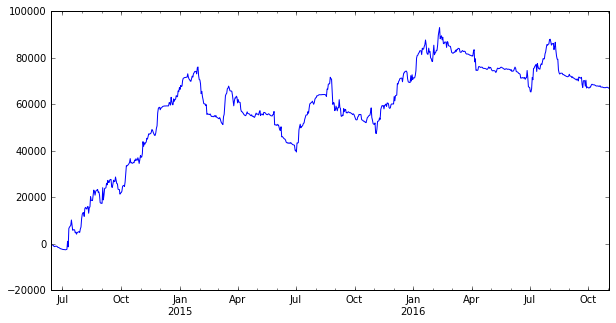

In [85]:
smgr.strategy.data.exo.plot()

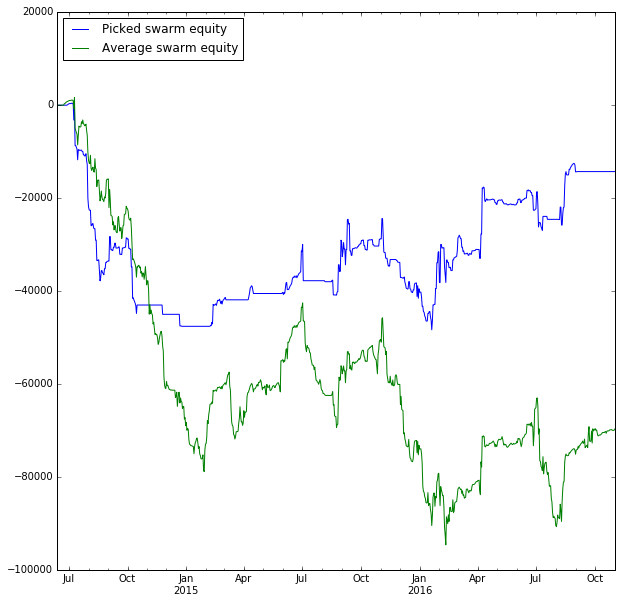

In [86]:
figsize(10,10)
smgr.picked_equity.plot(label='Picked swarm equity');
smgr.raw_equity.plot(label='Average swarm equity');
legend(loc=2);

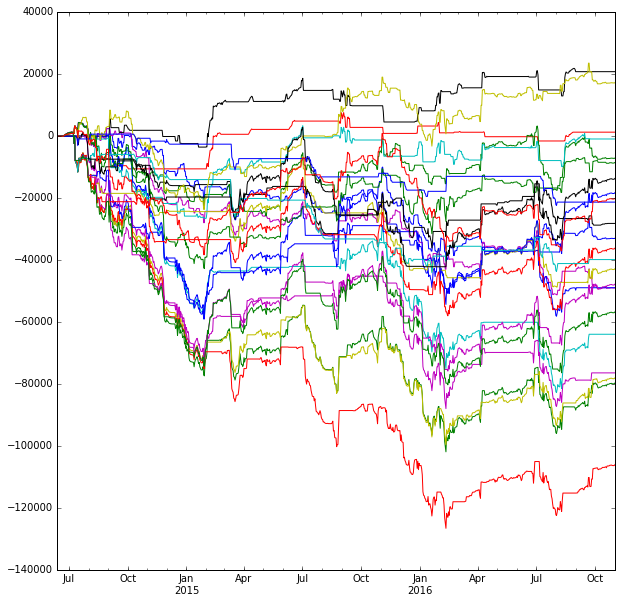

In [87]:
smgr.raw_swarm.plot(legend=False)

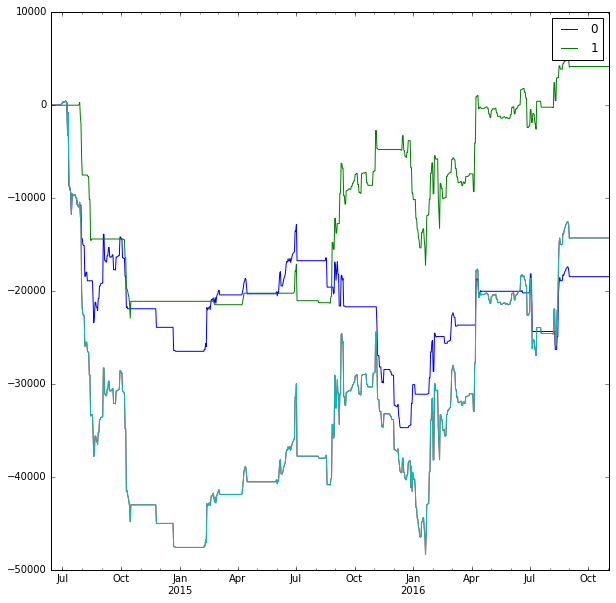

In [88]:
smgr.picked_swarm.plot()

smgr.picked_swarm.sum(1).plot(label='smgr.picked_swarm-sum')
smgr.picked_equity.plot(label='Picked swarm equity')

In [89]:
smgr.picked_swarm.diff().mean()

0   -21.121065
1     4.768008
dtype: float64

# Swarm exposure

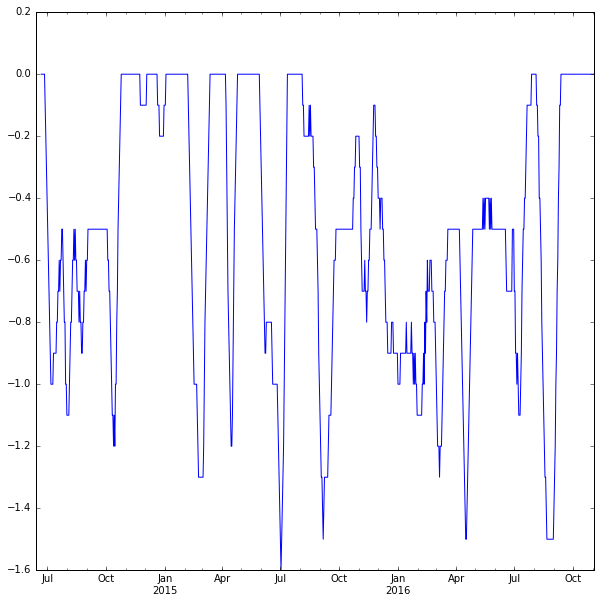

In [90]:
smgr.picked_exposure.sum(axis=1).rolling(10).mean().plot()

# Swarm statistics

#### Non-picked swarm stats

In [91]:
smgr.picked_stats

{'note:Not implemented yet'}

## Exo information

In [92]:
smgr.strategy.exoinfo.exo_info

{'dbdata': {'_id': ObjectId('581a7d3c20bb1d0dfe64c61d'),
  'calc_date': datetime.datetime(2016, 11, 2, 17, 10, 26, 907000),
  'name': 'CL_SmartEXO_Ichi_Put_Spread_150Delta_Bi',
  'position': {'_realized_pnl': 66858.63445834462,
   'positions': {'203183071': {'leg_name': '',
     'qty': -6.0,
     'value': -2731.9494587264257},
    '203183077': {'leg_name': 'bearish',
     'qty': 6.0,
     'value': 10622.229105540875}}},
  'series': b'\x80\x03cpandas.core.frame\nDataFrame\nq\x00)\x81q\x01}q\x02(X\x04\x00\x00\x00_typq\x03X\t\x00\x00\x00dataframeq\x04X\x05\x00\x00\x00_dataq\x05cpandas.core.internals\nBlockManager\nq\x06)\x81q\x07(]q\x08(cpandas.indexes.base\n_new_Index\nq\tcpandas.indexes.base\nIndex\nq\n}q\x0b(X\x04\x00\x00\x00dataq\x0ccnumpy.core.multiarray\n_reconstruct\nq\rcnumpy\nndarray\nq\x0eK\x00\x85q\x0fC\x01bq\x10\x87q\x11Rq\x12(K\x01K\x02\x85q\x13cnumpy\ndtype\nq\x14X\x02\x00\x00\x00O8q\x15K\x00K\x01\x87q\x16Rq\x17(K\x03X\x01\x00\x00\x00|q\x18NNNJ\xff\xff\xff\xffJ\xff\xff\xff\x

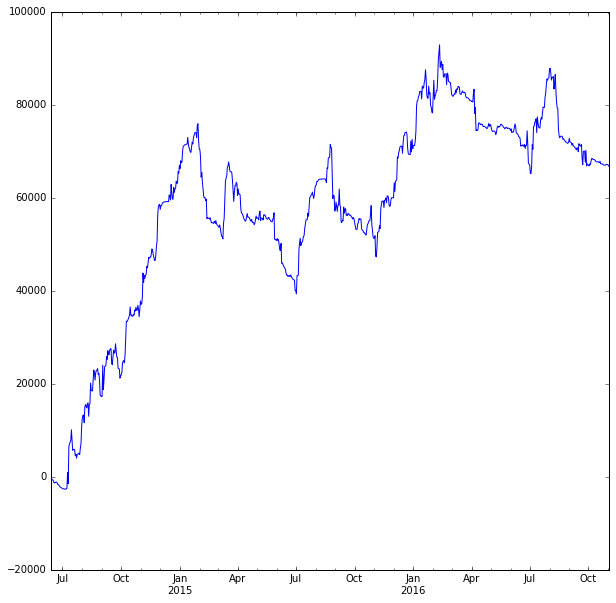

In [93]:
smgr.strategy.exoinfo.data.exo.plot()

### Global filter information (obsolete)


## Costs information (per 1-exo unit)

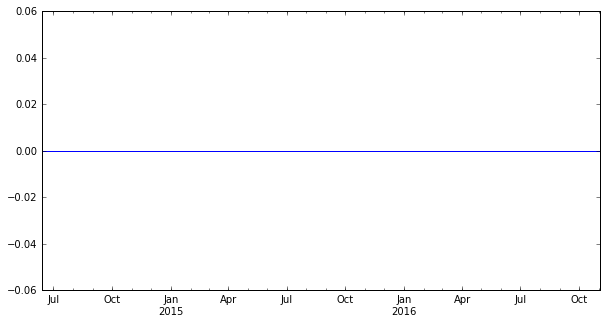

In [94]:
figsize(10,5)
smgr.strategy.costs.plot()

## Margin graphs

### EXO Margin (per 1 EXO unit)

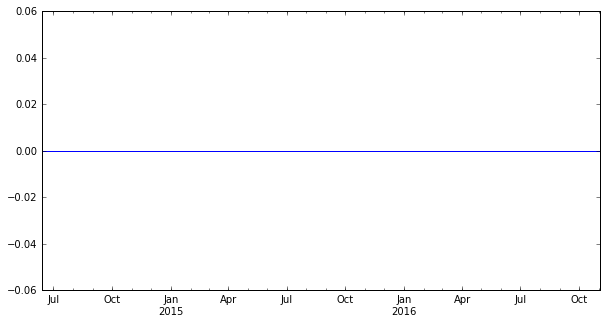

In [95]:
smgr.strategy.exoinfo.margin().plot()

# Saving results

In [96]:
smgr.save('./swarms/')

In [97]:
smgr.raw_swarm#.plot()

,"(-1, 0.1, 3, 50, 0, 0)","(-1, 0.1, 3, 50, 0, 1)","(-1, 0.1, 3, 50, 1, 0)","(-1, 0.1, 3, 50, 1, 1)","(-1, 0.2, 3, 50, 0, 0)","(-1, 0.2, 3, 50, 0, 1)","(-1, 0.2, 3, 50, 1, 0)","(-1, 0.2, 3, 50, 1, 1)","(-1, 0.3, 3, 50, 0, 0)","(-1, 0.3, 3, 50, 0, 1)",...,"(-1, 0.7, 3, 50, 1, 0)","(-1, 0.7, 3, 50, 1, 1)","(-1, 0.8, 3, 50, 0, 0)","(-1, 0.8, 3, 50, 0, 1)","(-1, 0.8, 3, 50, 1, 0)","(-1, 0.8, 3, 50, 1, 1)","(-1, 0.9, 3, 50, 0, 0)","(-1, 0.9, 3, 50, 0, 1)","(-1, 0.9, 3, 50, 1, 0)","(-1, 0.9, 3, 50, 1, 1)"
2014-06-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
